# Data Cleaning and EDA for Housing Price Forecast

This notebook shows the data cleaning process and EDA for a dataset I used in the housing price model. 
The main variables for the housing price forecasting model are housing price, the number of listings from Realtor.com, and population net inflow data from USPS change of address dataset. 

Contents: 
1. Cleaning housing price dataset from Realtor.com 
2. Cleaning USPS Change of Address Data
3. Merging housing data and USPS data
4. EDA with Descriptive Statistics 





In [29]:
import requests

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

# 1. Cleaning Housing Price Data

I obtain data on hoousing price and number of active listings by zip codes from Realtor.com Data Center. The data covers from July 2016 to December 2021. 
Below, I read the data from the Realtor.com website. 

In [30]:
url = 'https://econdata.s3-us-west-2.amazonaws.com/Reports/Core/RDC_Inventory_Core_Metrics_Zip_History.csv'
realtor = pd.read_csv(url)
realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892066 entries, 0 to 1892065
Data columns (total 40 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   month_date_yyyymm                        int64  
 1   postal_code                              int64  
 2   zip_name                                 object 
 3   median_listing_price                     float64
 4   median_listing_price_mm                  float64
 5   median_listing_price_yy                  float64
 6   active_listing_count                     float64
 7   active_listing_count_mm                  float64
 8   active_listing_count_yy                  float64
 9   median_days_on_market                    float64
 10  median_days_on_market_mm                 float64
 11  median_days_on_market_yy                 float64
 12  new_listing_count                        float64
 13  new_listing_count_mm                     float64
 14  new_listing_count_

For my hoousing price analysis, I use median_listing_price and active_listing_count. I drop other indicators. 

In [31]:
# Drop columns which is out of my focus. 
realtor = realtor[['month_date_yyyymm', 'postal_code', 'median_listing_price', 'active_listing_count']]

# Drop duplicate
realtor.drop_duplicates(inplace=True)

realtor.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892066 entries, 0 to 1892065
Data columns (total 4 columns):
 #   Column                Dtype  
---  ------                -----  
 0   month_date_yyyymm     int64  
 1   postal_code           int64  
 2   median_listing_price  float64
 3   active_listing_count  float64
dtypes: float64(2), int64(2)
memory usage: 72.2 MB


I rename year-month-date column. And I newerly define 'yearmonth' from year, month for future analysis.  

In [32]:
# rename month_date_yyyymm as date 
realtor_1 = realtor.rename(columns={'month_date_yyyymm': 'date'})

# Define year and month column
realtor_1['date'] = realtor_1['date'].astype(str)
realtor_1['year'] = realtor_1['date'].str[:4]
realtor_1['month'] = realtor_1['date'].str[4:]

# Define yearmonth column
cols = ['year', 'month']
realtor_1['yearmonth']= realtor_1[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

I change date to the datatime format, and set date and zipcode to index. 

In [33]:
# change 'date' to the datatime
realtor_1.date=pd.to_datetime(realtor_1.date, format='%Y%m')

# Set Multiindex (date and zips)
realtor_m = realtor_1.set_index(['postal_code', 'date']).sort_index() 

realtor_m.head()

median_listing_price  active_listing_count  year  \
postal_code date                                                           
1001        2016-07-01              209000.0                  60.0  2016   
            2016-08-01              229900.0                  67.0  2016   
            2016-09-01              219900.0                  65.0  2016   
            2016-10-01              209900.0                  65.0  2016   
            2016-11-01              209000.0                  59.0  2016   

                       month yearmonth  
postal_code date                        
1001        2016-07-01    07    201607  
            2016-08-01    08    201608  
            2016-09-01    09    201609  
            2016-10-01    10    201610  
            2016-11-01    11    201611

#### Handling missing values in housing data 

Report the number of missing values. 

In [34]:
realtor_m.isnull().sum()

median_listing_price    3716
active_listing_count    3716
year                       0
month                      0
yearmonth                  0
dtype: int64

For 'median_listing_price', 'active_listing_count', I use interpolation to fill the misisng values. 

In [35]:
# using interpolate() to fill the missing values 

interpolate = ['median_listing_price', 'active_listing_count']

for x in interpolate:
    realtor_m[x] = realtor_m[x].interpolate()

realtor_m.isnull().sum()


median_listing_price    0
active_listing_count    0
year                    0
month                   0
yearmonth               0
dtype: int64

Now, all housing data is filled.   

# 2. Cleaning USPS Change of Address Data

The United States Postal Service’s National Change of Address (NCOA) dataset (https://about.usps.com/who/legal/foia/library.htm) has zip code-month level inflow and outflow data for all US zip. I used this data to create population net inflow in each zip code.  

Data are stored by year. So, in below, I read data and merge files. 

In [36]:
usps18 = pd.read_csv('../Data/usps/Y2018.csv')
usps19 = pd.read_csv('../Data/usps/Y2019.csv')
usps20 = pd.read_csv('../Data/usps/Y2020.csv')
usps21 = pd.read_csv('../Data/usps/Y2021.csv')
usps22 = pd.read_csv('../Data/usps/Y2022.csv')

usps1819 = usps18.append(usps19, ignore_index=True)
usps181920 = usps1819.append(usps20, ignore_index=True)
usps18192021 = usps181920.append(usps21, ignore_index=True)
usps = usps18192021.append(usps22, ignore_index=True)
usps.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250709 entries, 0 to 1250708
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   YYYYMM              1250709 non-null  int64 
 1   ZIPCODE             1250709 non-null  object
 2   CITY                1250709 non-null  object
 3   STATE               1250709 non-null  object
 4   TOTAL FROM ZIP      1250709 non-null  int64 
 5   TOTAL BUSINESS      1250709 non-null  int64 
 6   TOTAL FAMILY        1250709 non-null  int64 
 7   TOTAL INDIVIDUAL    1250709 non-null  int64 
 8   TOTAL PERM          1250709 non-null  int64 
 9   TOTAL TEMP          1250709 non-null  int64 
 10  TOTAL TO ZIP        1250709 non-null  int64 
 11  TOTAL BUSINESS.1    1250709 non-null  int64 
 12  TOTAL FAMILY.1      1250709 non-null  int64 
 13  TOTAL INDIVIDUAL.1  1250709 non-null  int64 
 14  TOTAL PERM.1        1250709 non-null  int64 
 15  TOTAL TEMP.1        1250709 non-

I define 'net population inflow' for each zip code. Net inflow = Total population inflow - Total population outflow 

In [37]:
# Calcuate net inflow to the zipcode 
usps['netinflow'] = usps['TOTAL TO ZIP'] - usps['TOTAL FROM ZIP']

Below, I clean up ZIPCODE cells and rename it to 'zips'. Then I dropped unecessary columns. 

In [38]:
# cleaning zipcode and rename it to zips 
usps.ZIPCODE = usps.ZIPCODE.map(lambda x:x.strip('=""'))
usps.rename({'ZIPCODE':'zips', 'YYYYMM':'yearmonth'}, axis=1, inplace=True)

# Drop unnecessary columns
usps.drop(usps.iloc[:, 4:-1], inplace = True, axis = 1)
usps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250709 entries, 0 to 1250708
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   yearmonth  1250709 non-null  int64 
 1   zips       1250709 non-null  object
 2   CITY       1250709 non-null  object
 3   STATE      1250709 non-null  object
 4   netinflow  1250709 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 47.7+ MB


Check missing values. 

In [39]:
usps.isnull().sum()

yearmonth    0
zips         0
CITY         0
STATE        0
netinflow    0
dtype: int64

There is no missing values. 

In [40]:
# Save for later 
usps.to_csv('Data/usps.csv', index = False)

# 3 . Merge USPS population net inflow data to housing price data 

I merge USPS data (created in section 2) to the housing price data (created in section 1). Net population inflow data is one of the input variable for the housing price forecasting model.  

First, I reset the index of housing price data (realtor_m) and rename column names to match between two datasets. I change 'postal code' to 'zips'. And then, I merge USPS data into housing price data.

In [52]:
# reset index
realtor_m.reset_index(inplace=True)

# rename postal_code to zips 
realtor_m.rename({'postal_code':'zips'}, axis=1, inplace=True)

realtor_m['yearmonth']= realtor_m.yearmonth.astype(int)

# read the USPS data 
usps = pd.read_csv('Data/usps.csv')

# Merge USPS and Redfine over zipcodes and yearmonth 
df_housing = realtor_m.merge(usps, how='left', on=['zips', 'yearmonth'])

# Drop unnecessary columns
cols_drop = ['STATE', 'CITY']
df_housing.drop(cols_drop, axis=1, inplace=True) 

# Drop duplicates 
df_housing.drop_duplicates(inplace=True)


df_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892066 entries, 0 to 1892065
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   index                 int64         
 1   zips                  int64         
 2   date                  datetime64[ns]
 3   median_listing_price  float64       
 4   active_listing_count  float64       
 5   year                  object        
 6   month                 object        
 7   yearmonth             int64         
 8   netinflow             float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 144.4+ MB


#### Drop zip codes out side of Washington DC metro area
My analysis focus on Washington DC metro area. So, I limits zip codes which belongs to Wshington DC metro area. I use GeoIDs to filter the zip codes in DC area.  

In the cell below, I merge df_geo (GeoIDs data) to df_hoousing data, and I drop zipcodes outside of the DC area.

In [53]:
# read df_geo
df_geo=pd.read_csv('Data/df_geo.csv')

# Merge df_housing and df_geo 
df = df_housing.merge(df_geo, how='left' ,left_on='zips', right_on='ZIP') 

# Keep if czname is 'Washington DC'  
df = df[df['czname']=='Washington DC']
df.head()

,index,zips,date,median_listing_price,active_listing_count,year,month,yearmonth,netinflow,countyfips,...,USPS_ZIP_PREF_CITY,RES_RATIO_x,BUS_RATIO_x,OTH_RATIO,TOT_RATIO_x,TOT_RATIO_y,RES_RATIO_y,BUS_RATIO_y,nearest_city,distance
379908,379908,20001,2016-07-01,699000.0,84.0,2016,07,201607,NaN,11001.0,...,WASHINGTON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Washington DC,1.925368
379909,379909,20001,2016-08-01,697000.0,63.0,2016,08,201608,NaN,11001.0,...,WASHINGTON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Washington DC,1.925368
379910,379910,20001,2016-09-01,697450.0,74.0,2016,09,201609,NaN,11001.0,...,WASHINGTON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Washington DC,1.925368
379911,379911,20001,2016-10-01,729900.0,87.0,2016,10,201610,NaN,11001.0,...,WASHINGTON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Washington DC,1.925368
379912,379912,20001,2016-11-01,725000.0,95.0,2016,11,201611,NaN,11001.0,...,WASHINGTON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Washington DC,1.925368


#### Drop zip codes which has less than 10 listings. 

If a zip code has only a few lisitngs, one very expensive house will impact a lot. So I drop a zip code which has less than 20 listings.

First, I created a dummy variable which =1 if the lisitng is less than 20. Using this dummy variable, I drop the zipcodes. 

In [54]:
# Create a list of zipcodes which has less than 20 listings. 

# Count the number of listing by zip 
ave_listing = df.groupby('ZIP').mean()['active_listing_count']

# Create a dummy variable which =1 if number of active lisitng < 20. Store the data in dataframe.  
ave_listing20= pd.DataFrame(ave_listing<20).astype('int')

# change the name of the dummy variable to listing20
ave_listing20.rename({'active_listing_count':'listing20'}, axis=1, inplace=True)

# Merge ave_listing20 into df_wfh 
df_20 = df.merge(ave_listing20, on='ZIP', how ='left')

# Drop zipcode if listing20 = 1 
df_final = df_20[df_20.listing20==0]

df_final.drop('listing20', axis=1, inplace=True)


In [55]:
x= df.zips.nunique()  
y=  sum(ave_listing20.listing20==1)   
z= df_final.zips.nunique() 
print(f'Among total of {x} zip codes, I dropped {y} zip codes.')
print(f'Final data includes {z} zip codes.')


Among total of 302 zip codes, I dropped 113 zip codes.
Final data includes 189 zip codes.


## Save df_final as df_realtor.csv for later use. 

In [56]:
df_final.to_csv('Data/df_realtor.csv', index=False)

# 4. EDA

First, I check the statistics of housing price, number of listings, and population net inflow. 

In [57]:
df_final[['median_listing_price','active_listing_count', 'netinflow']].describe()

,median_listing_price,active_listing_count,netinflow
count,1.323000e+04,13230.000000,9828.000000
mean,5.683052e+05,58.034089,-17.162190
std,3.124637e+05,43.012570,60.820021
min,1.390000e+05,0.000000,-733.000000
25%,3.695000e+05,27.000000,-41.000000
50%,4.924500e+05,46.000000,-6.000000
75%,6.470000e+05,78.000000,16.000000
max,3.825000e+06,299.000000,301.000000


In [58]:
6.095000e+06

6095000.0

Housing price varied from 139k to 6.1 million. Median is around 488K. Average is 571k. Average zip code has about 51 listings, and -16 net inflow. 

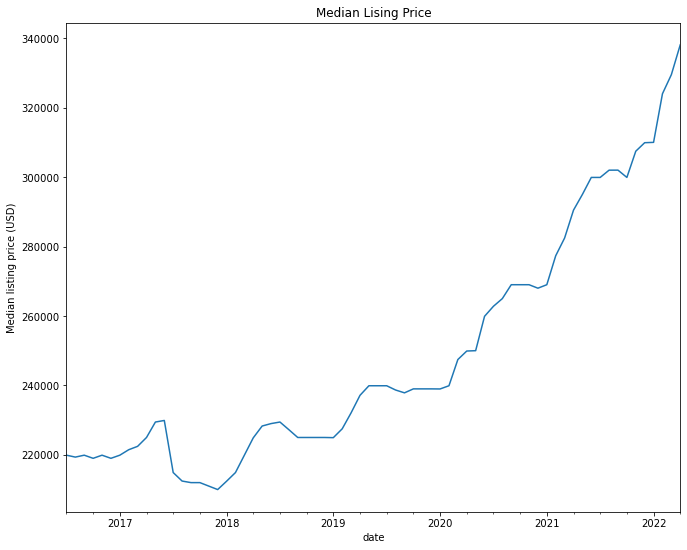

In [59]:
realtor_m.groupby(['date']).median()['median_listing_price'].plot()
plt.ylabel('Median listing price (USD)')
plt.title('Median Lising Price');

On average, the housing price in this area shows the strong upward trend over time. 

Now I pick one zip code (=20009) inside of Washington DC and check the trend.  

#### Housing Price

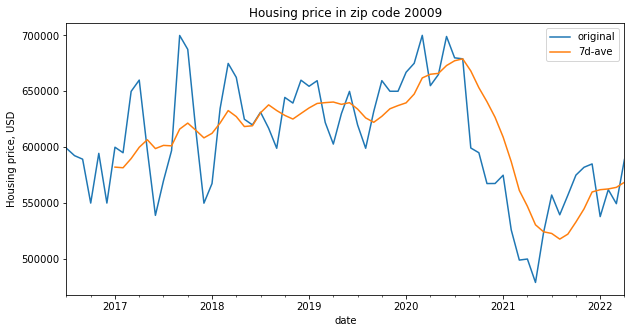

In [60]:
#commercial = df.loc[(11001, ),]['commercial'].plot()
realtor_m[realtor_m.zips==20009].groupby(['date']).mean() ['median_listing_price'].plot(figsize=(10, 8), label='original')
realtor_m[realtor_m.zips==20009].groupby(['date']).mean() ['median_listing_price'].rolling(7).mean().plot( label ='7d-ave', figsize=(10,5))

plt.ylabel('Housing price, USD')
plt.title('Housing price in zip code 20009')
plt.legend();

Housing price clearly shows some seasonal trends. In terms of trend, there was a significant drop in March 2020, when the US declared a national emergency. 

Next, I use seasonal decomposition to detect seasonality, trend, and any noise in the housing price data. I set period=12 because this is the monthly data.

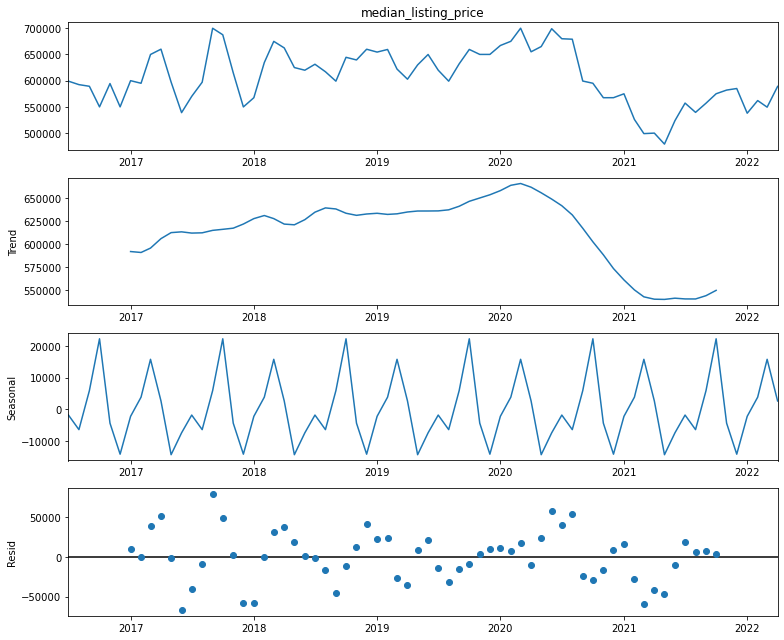

In [61]:
# Set a data frame of zip code = 20009
df20009 = realtor_m[realtor_m.zips==20009]
# set date as index 
df20009 = df20009.set_index(['date']).sort_index() 

# Plot seasonal Decomposition 

rcParams['figure.figsize'] = 11, 9

decomposition = seasonal_decompose(df20009.median_listing_price, model='additive', period=12)
fig = decomposition.plot();

Housing follows some seasonal trends; increase in spring and fall, drop in winter and early summer. In terms of long term trend, the price shows a increasing trend until 2020 and then suddenly drops in March 2020.

#### Number of Active Listing

Next, I check seasonality and trend in number of active listings in zip code 20009

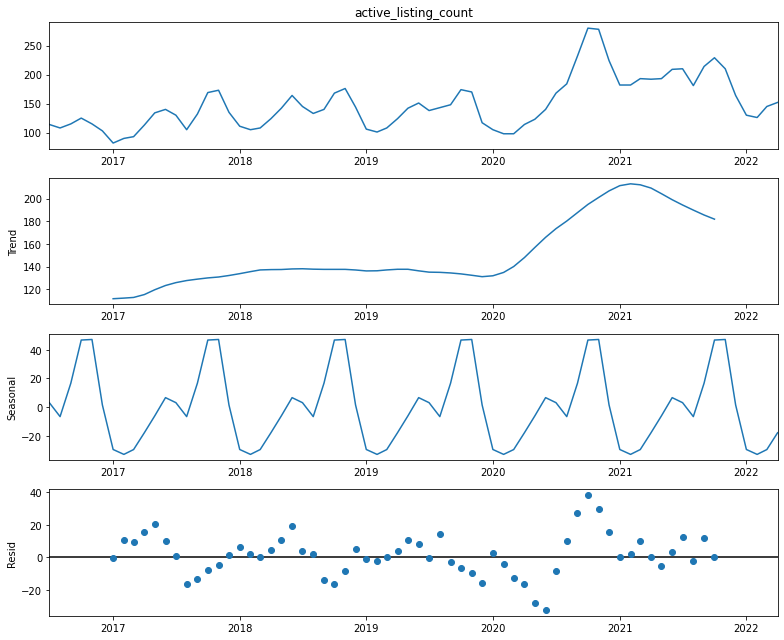

In [62]:
# Set a data frame of zip code = 20009
df20009 = realtor_m[realtor_m.zips==20009]
# set date as index 
df20009 = df20009.set_index(['date']).sort_index() 

# Plot seasonal Decomposition 

rcParams['figure.figsize'] = 11, 9

decomposition = seasonal_decompose(df20009.active_listing_count, model='additive', period=12)
fig = decomposition.plot();

In terms of long term trend, the number of active listings jumped up during 2020, this mirroed the rising housing price in 2020 in this zip code. 

Number of listings has clear seasonal trends-Increase until Nov and drop in Dec/Jan. 